# HM model (working ?)

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

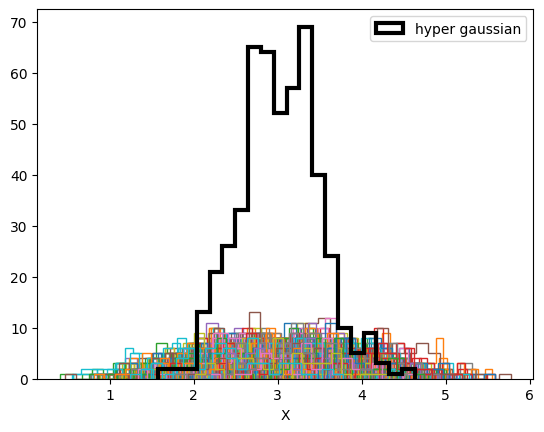

In [2]:
def generate_data(mean, scale, size):
    """
    Function to generate a Gaussian distribution with specified mean, scale and size. 
    """
    return np.random.normal(loc=mean, scale=scale, size=size)

# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter
true_child_scale = 0.5

N_obs = 500
size_child = 50

# Hypothesis for parent gaussian 
parent_gaussian = generate_data(true_parent_mean, true_parent_scale, size=N_obs)

child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis], scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()

In [3]:
def log_likelihood(params):
    parent_mean, parent_scale = params
    weights = np.log(np.sum(
                (2 * np.pi * true_child_scale**2)**(-0.5) * \
                np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / \
                (2 * true_child_scale**2)),
                axis=1))
    chi_sq = ((child_gaussian.mean(axis=1) - parent_mean) / (2 * parent_scale))**2
    return - 0.5 * N_obs * np.log(2 * np.pi * parent_scale**2 * size_child**2) - np.sum(chi_sq + weights)

In [4]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial)
mu_ml, sigma_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_ml))
print("sigma = {0:.3f}".format(sigma_ml))

Maximum likelihood estimates:
mu = 3.024
sigma = 0.338


In [5]:
def log_prior(params):
    parent_mean, parent_scale = params
    # Flat priors 
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 5):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [6]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:40<00:00, 124.63it/s]


State([[3.01009295 0.33203974]
 [3.0526986  0.33261645]
 [3.06805447 0.34715897]
 [2.99721364 0.33943859]
 [3.0103172  0.33506894]
 [3.00748051 0.36486003]
 [3.01091415 0.34451505]
 [3.01310861 0.31500519]
 [3.05676759 0.33601954]
 [3.02236847 0.32094495]
 [3.05943024 0.34876917]
 [3.03235177 0.34099786]
 [3.02176283 0.33000137]
 [3.0213312  0.34663334]
 [3.02165224 0.34340601]
 [3.04286269 0.33846384]
 [3.00512756 0.3314932 ]
 [3.02443638 0.31637069]
 [3.00789373 0.3336582 ]
 [3.0189689  0.34451332]
 [3.03076388 0.35463269]
 [3.07445059 0.34466622]
 [3.01473219 0.33765631]
 [3.01579849 0.32798348]
 [3.02638572 0.34164833]
 [2.98461039 0.33807763]
 [3.04191386 0.33241002]
 [3.0461503  0.3170762 ]
 [3.06463624 0.34437254]
 [2.98918445 0.32503468]
 [3.05633321 0.3265812 ]
 [2.95616427 0.35976431]
 [3.03133736 0.35489725]
 [2.99708395 0.33011594]
 [3.01340562 0.30922778]
 [3.03960761 0.33562879]
 [3.04384971 0.33558398]
 [3.05338647 0.33221106]
 [3.04664326 0.33582188]
 [3.04026591 0.3478

Text(0.5, 0, 'step number')

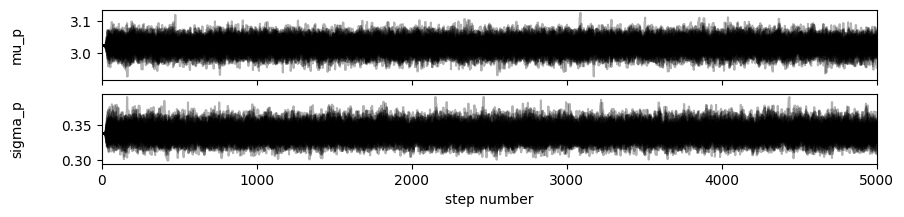

In [7]:
fig, axes = plt.subplots(2, figsize=(10, 2), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [8]:
tau = sampler.get_autocorr_time()
print(tau)

[28.85625371 29.79349574]


In [9]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(16300, 2)


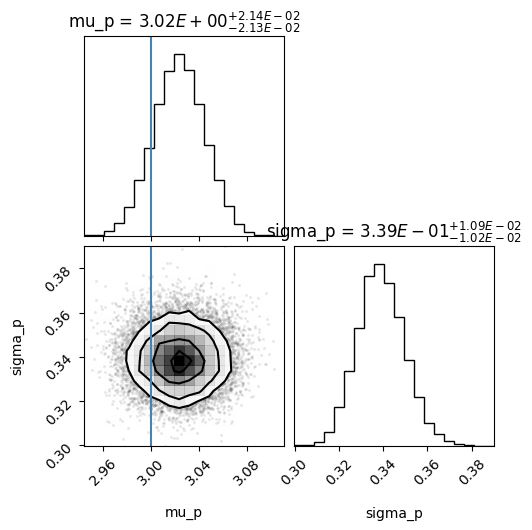

In [10]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# BIMODAL HM

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

(array([8., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([1.55083587e-43, 2.25883851e-02, 4.51767702e-02, 6.77651553e-02,
        9.03535404e-02, 1.12941925e-01, 1.35530311e-01, 1.58118696e-01,
        1.80707081e-01, 2.03295466e-01, 2.25883851e-01, 2.48472236e-01,
        2.71060621e-01, 2.93649006e-01, 3.16237391e-01, 3.38825776e-01,
        3.61414162e-01, 3.84002547e-01, 4.06590932e-01, 4.29179317e-01,
        4.51767702e-01]),
 <BarContainer object of 20 artists>)

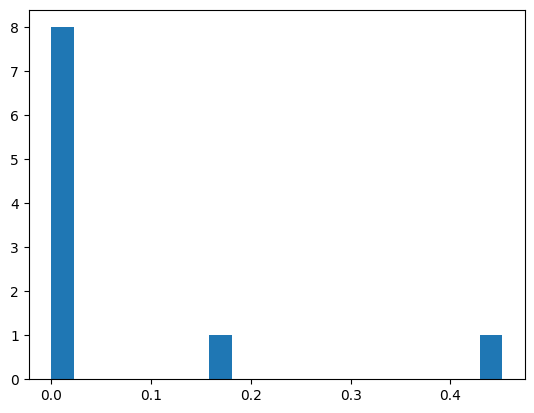

In [36]:
N_obs = 10
size_child = 50

x = np.linspace(0, 10, N_obs)

GAUSSIAN = lambda x, mu, sigma : (2 * np.pi * sigma)**(-0.5) * np.exp(- ((x - mu)**2 / (2 * sigma**2)))
generate_data = lambda x, mu_A, sigma_A, mu_B, sigma_B : GAUSSIAN(x, mu_A, sigma_A) + GAUSSIAN(x, mu_B, sigma_B)



true_parent_mean_A = 3.0 # hyperparameter
true_parent_scale_A = .5 # hyperparameter
true_parent_mean_B = 5.0 # hyperparameter
true_parent_scale_B = .3 # hyperparameter

parent_gaussian = np.random.choice(x, size=N_obs, p=generate_data(x, true_parent_mean_A, true_parent_scale_A, true_parent_mean_B, true_parent_scale_B) / \
                                np.sum(generate_data(x, true_parent_mean_A, true_parent_scale_A, true_parent_mean_B, true_parent_scale_B)))

plt.hist(GAUSSIAN(x, true_parent_mean_A, true_parent_scale_A), bins=20)
#plt.hist(GAUSSIAN(x, true_parent_mean_B, true_parent_scale_B))
#plt.hist(generate_data(x, true_parent_mean_B, true_parent_scale_B, true_parent_mean_B, true_parent_scale_B))